In [1]:
import torch
from fastai.vision.all import *
import os

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

/home/ippen/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available on this system.


In [2]:
torch.cuda.empty_cache()

In [3]:
# Fix Display behavior in Jupyter Notebooks for VS Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [4]:
import re

def get_state_label(file_path):
    filename = os.path.basename(file_path)
    state_pattern = r"__class_(\w+)-"
    state_match = re.search(state_pattern, filename)
    if state_match:
        return state_match.group(1)
    else:
        raise ValueError(f"State-Class pattern not found in filename: {filename}")

def get_pictogram_label(file_path):
    filename = os.path.basename(file_path)
    pictogram_pattern = r"-(\w+).png$"
    pictogram_match = re.search(pictogram_pattern, filename)
    if pictogram_match:
        return pictogram_match.group(1)
    else:
        raise ValueError(f"Pictogram-Class pattern not found in filename: {filename}")

In [5]:
import albumentations

class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_train_aug(): return albumentations.Compose([
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=1.0
            )
])

In [6]:
dataset_path = "/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_rect_combined/"
train_folder = 'train'
valid_folder = 'valid'

dblock_state = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   n_inp=1,
                   get_items=get_image_files,
                   get_y=get_state_label,
                   item_tfms=[Resize(224, ResizeMethod.Pad, pad_mode='zeros'), AlbumentationsTransform(get_train_aug())],
                   batch_tfms=[*aug_transforms(size=224, do_flip=False, max_rotate=3, max_warp=0.1), Contrast(max_lighting=0.25)])

dls_state = dblock_state.dataloaders(dataset_path, path=dataset_path, train=train_folder, valid=valid_folder, bs=64)

In [7]:
print("Train size: " + str(len(dls_state.train.items))+ " | Valid size: " + str(len(dls_state.valid.items)))

Train size: 17280 | Valid size: 4319


In [8]:
dls_state.vocab

['green', 'off', 'red', 'red_yellow', 'yellow']

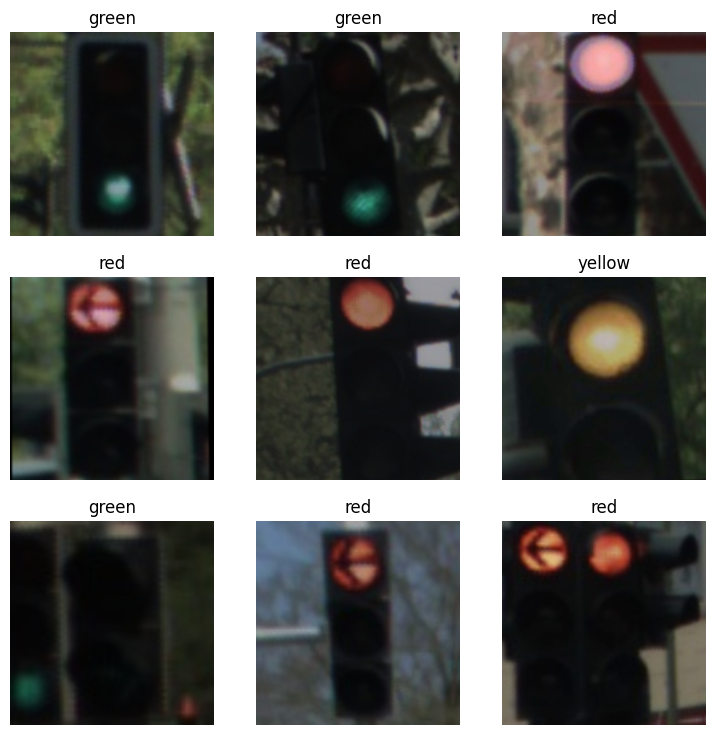

In [9]:
dls_state.show_batch(max_n=9)

In [10]:
def state_loss(inp, state): return F.cross_entropy(inp ,state)

In [11]:
learn_state = vision_learner(dls_state, convnext_tiny, loss_func=state_loss, metrics=error_rate, n_out=5)

/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
learn_state.model[-1] = nn.Sequential(*learn_state.model[-1], nn.Softmax(dim=1))

SuggestedLRs(valley=0.005248074419796467)

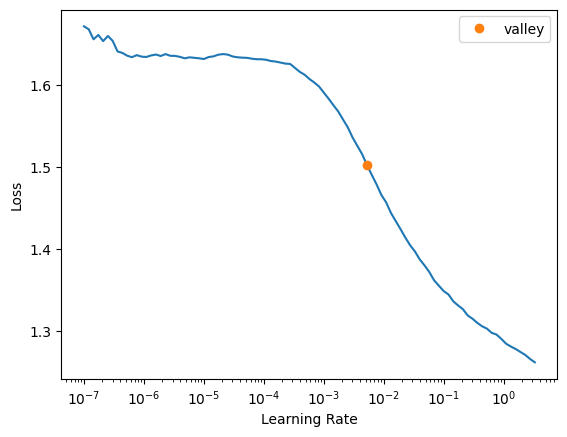

In [13]:
learn_state.lr_find()

In [14]:
learn_state.fine_tune(2, 5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.956620,0.948019,0.043297,02:13
1,0.928589,0.923272,0.018754,02:13


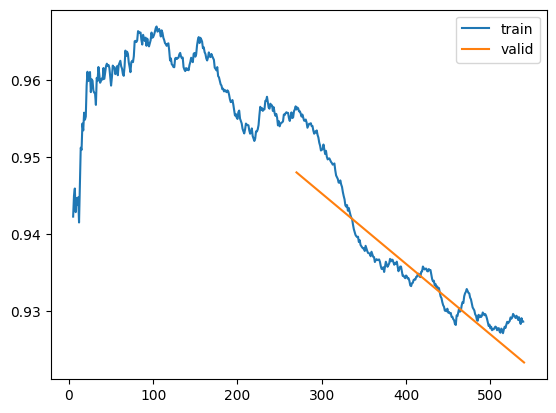

In [15]:
learn_state.recorder.plot_loss()

### Pictogram

In [16]:
dataset_path = "/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_rect_combined/"
train_folder = 'train'
valid_folder = 'valid'

dblock_pictogram = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   n_inp=1,
                   get_items=get_image_files,
                   get_y=get_pictogram_label,
                   item_tfms=[Resize(224, ResizeMethod.Pad, pad_mode='zeros'), AlbumentationsTransform(get_train_aug())],
                   batch_tfms=[*aug_transforms(size=224, do_flip=False, max_rotate=3, max_warp=0.1), Contrast(max_lighting=0.25)])

dls_pictogram = dblock_pictogram.dataloaders(dataset_path, path=dataset_path, train=train_folder, valid=valid_folder, bs=64)

In [17]:
print("Train size: " + str(len(dls_pictogram.train.items))+ " | Valid size: " + str(len(dls_pictogram.valid.items)))

Train size: 17280 | Valid size: 4319


In [18]:
dls_pictogram.vocab

['arrow_left', 'arrow_right', 'arrow_straight', 'circle']

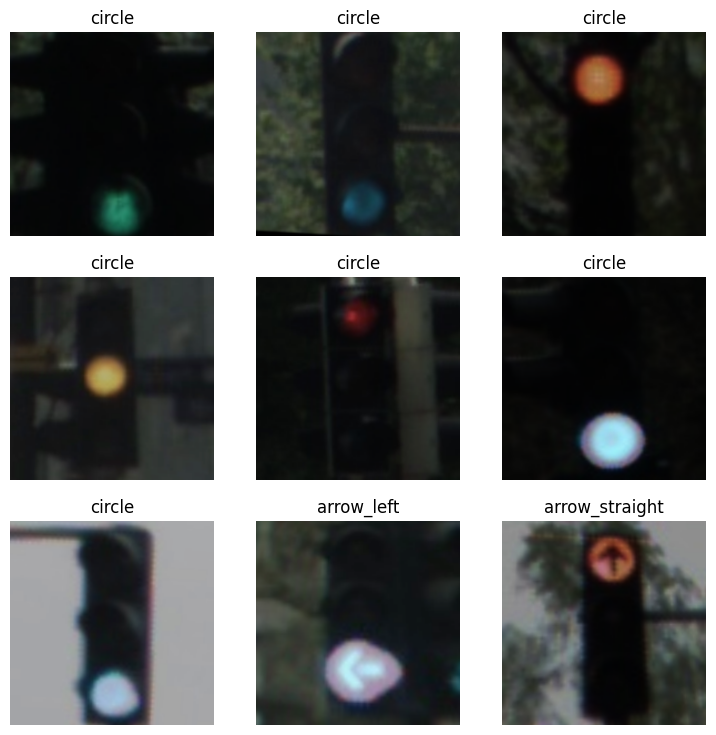

In [19]:
dls_pictogram.show_batch(max_n=9)

In [20]:
def pictogram_loss(inp, pictogram): return F.cross_entropy(inp,pictogram)

In [21]:
learn_pictogram = vision_learner(dls_pictogram, convnext_tiny, loss_func=pictogram_loss, metrics=error_rate, n_out=4)

In [22]:
learn_pictogram.model[-1] = nn.Sequential(*learn_pictogram.model[-1], nn.Softmax(dim=1))

SuggestedLRs(valley=0.007585775572806597)

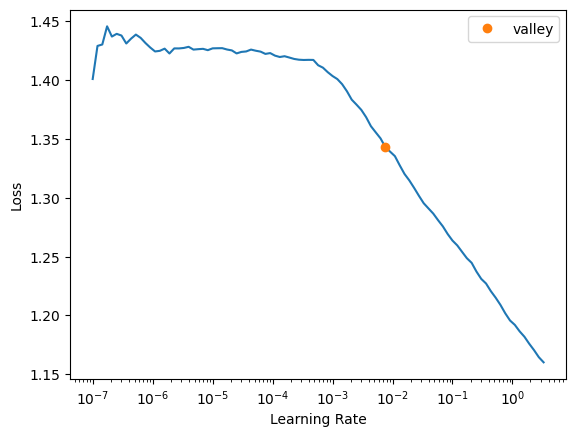

In [23]:
learn_pictogram.lr_find()

In [24]:
learn_pictogram.fine_tune(2, 8e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.798778,0.787108,0.043992,02:13
1,0.783445,0.769898,0.026395,02:13


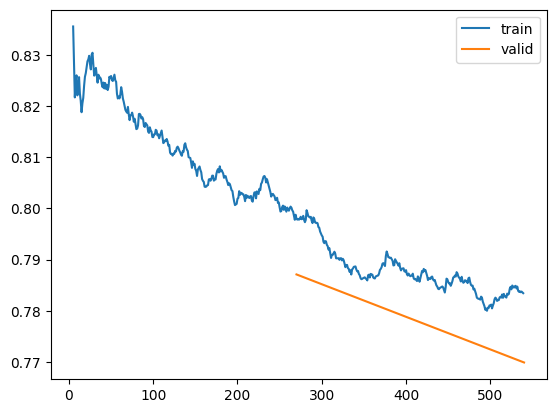

In [25]:
learn_pictogram.recorder.plot_loss()

In [26]:
#learn_pictogram.save('tl_v2.3-pictogram')

In [27]:
def predict_state(img_path):
    tst_dl_state = learn_state.dls.test_dl([img_path])
    pred_state = learn_state.get_preds(dl=tst_dl_state)
    return pred_state[0][0]

def predict_pictogram(img_path):
    tst_dl_pictogram = learn_pictogram.dls.test_dl([img_path])
    pred_pictogram = learn_pictogram.get_preds(dl=tst_dl_pictogram)
    return pred_pictogram[0][0]


def get_class(pred_state, pred_pictogram):
    states = ["green", "off", "red", "red_yellow", "yellow"]
    pictogram = ["arrow_left", "arrow_right", "arrow_straight", "circle"]
    return states[pred_state.argmax()] + " " + pictogram[pred_pictogram.argmax()]

def get_probability(pred_state, pred_pictogram):
    return max(pred_state), max(pred_pictogram)


tensor([9.9909e-01, 1.0151e-04, 3.9518e-05, 6.7535e-04, 9.0266e-05])

tensor([5.1503e-07, 3.2774e-08, 1.4437e-09, 1.0000e+00])

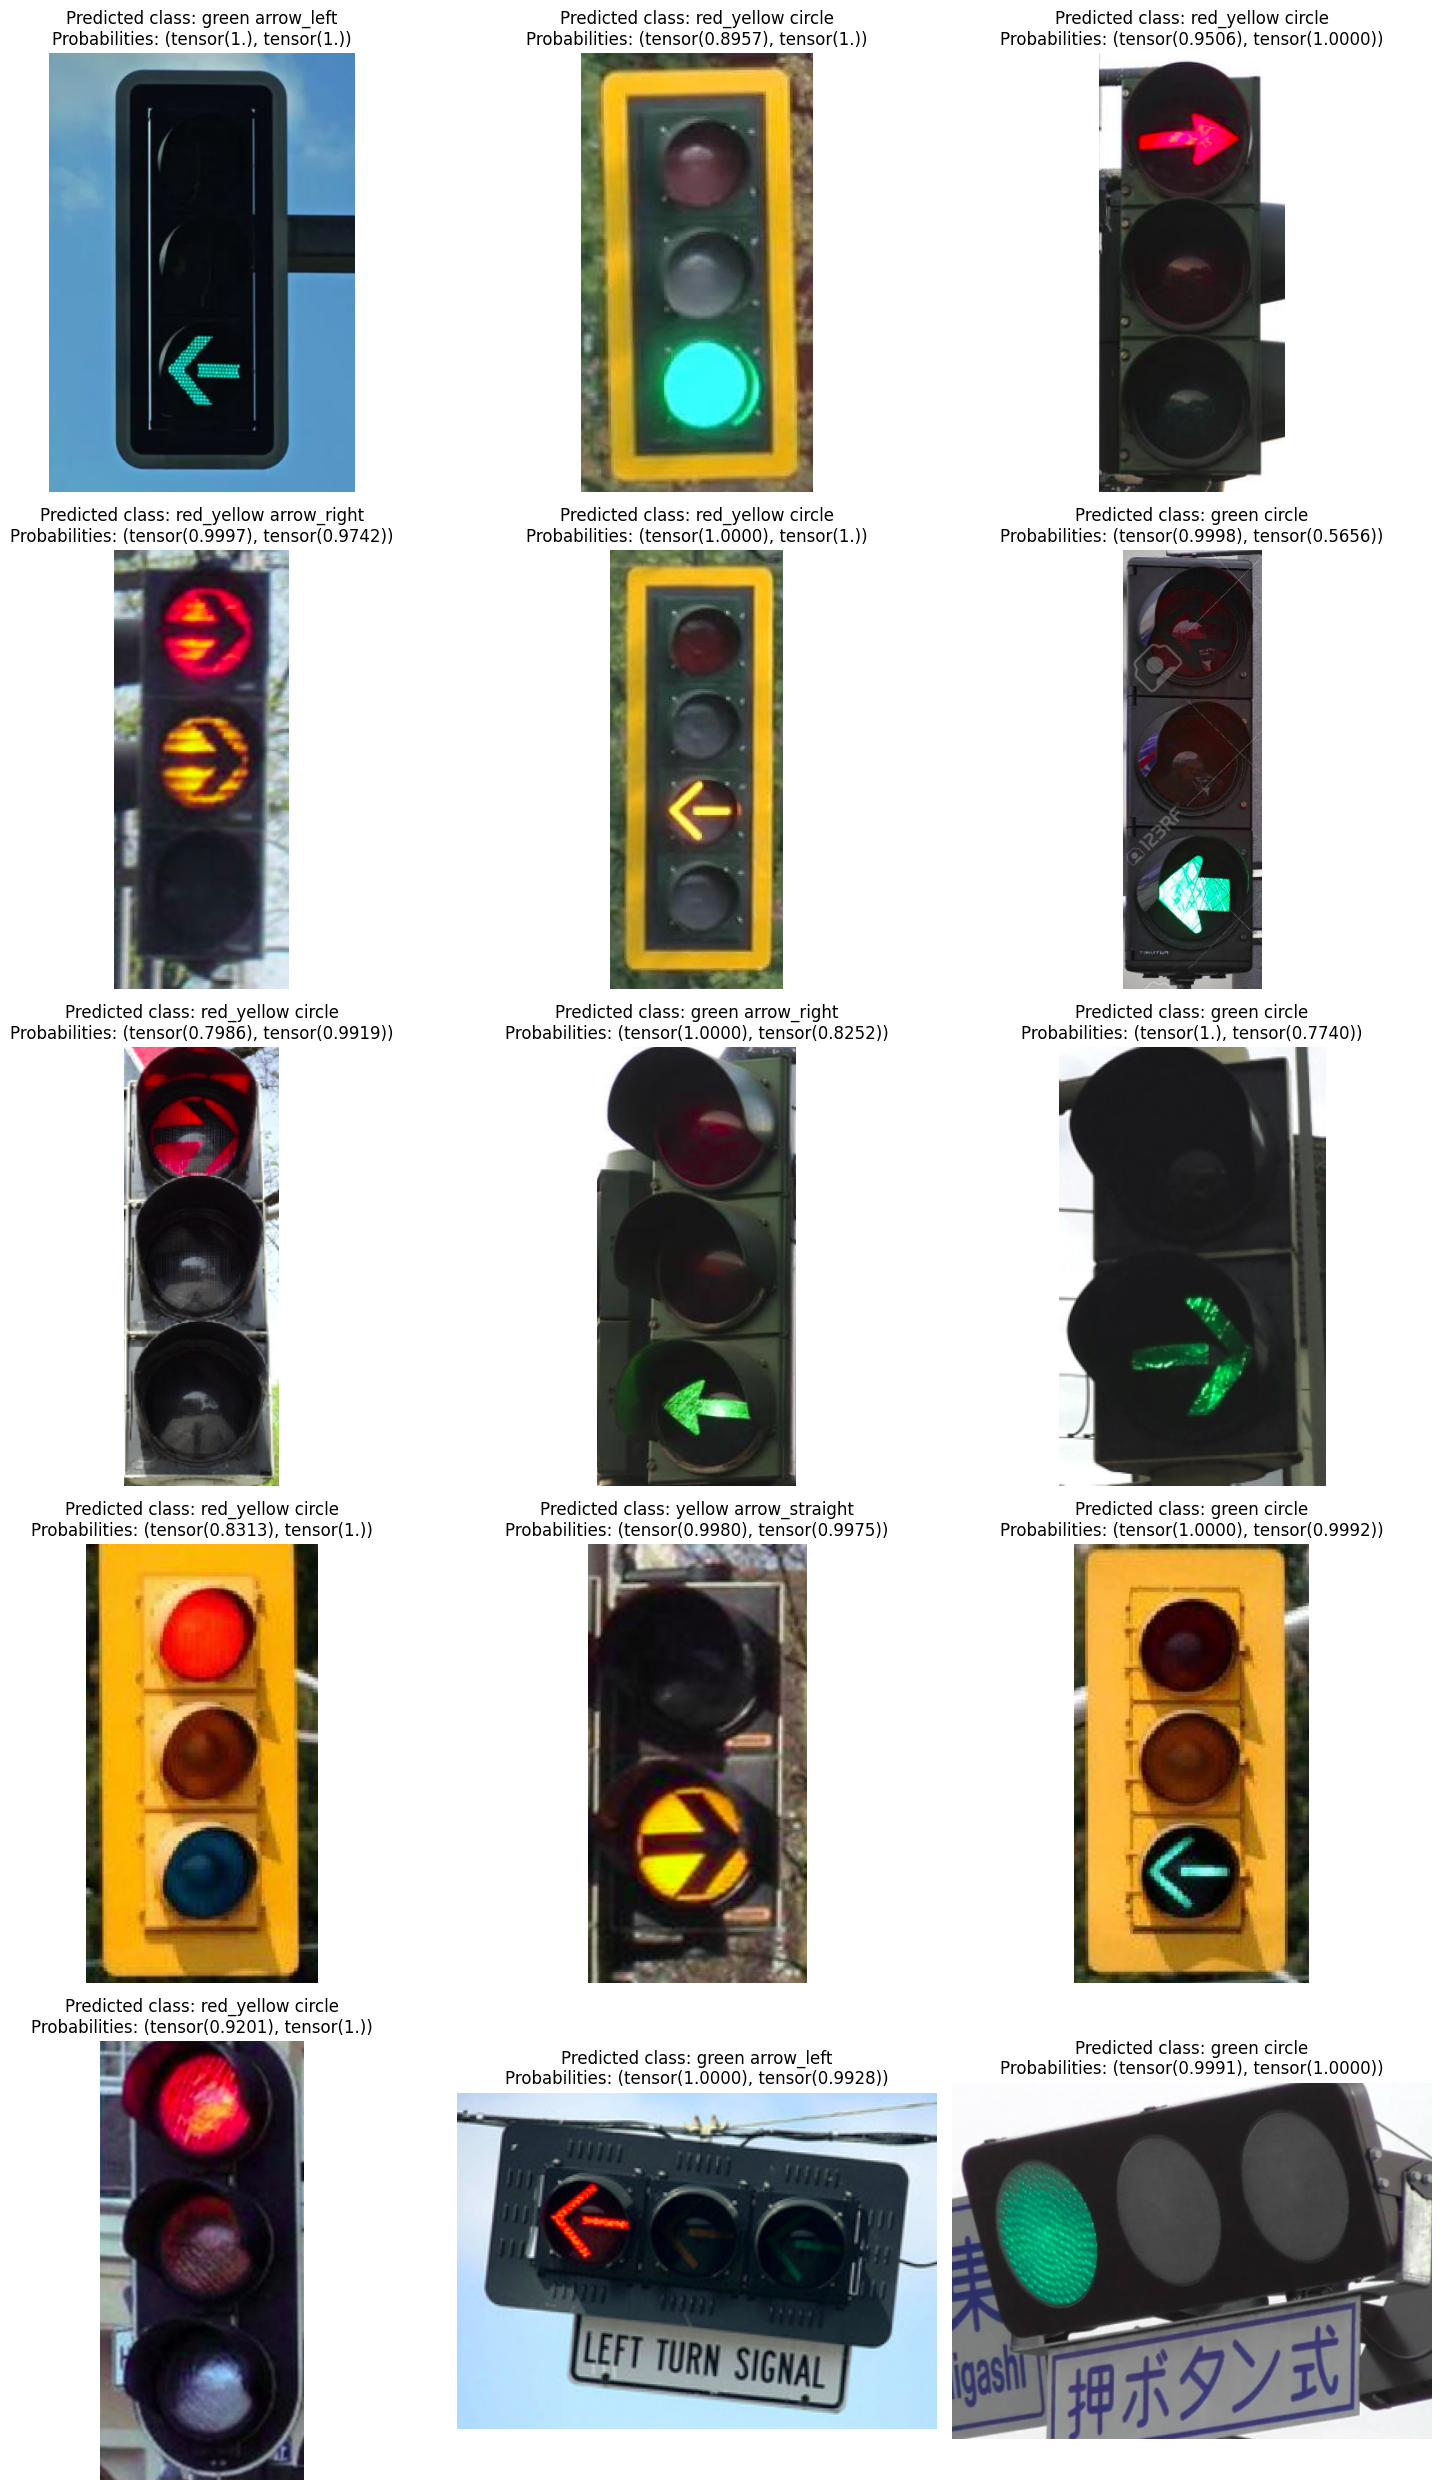

In [28]:
import matplotlib.pyplot as plt

folder_path = "/home/ippen/personal/traffic-light-classification/datasets/samples"

# Get a list of all image files in the folder
image_files = get_image_files(folder_path)

# Define the cropping transformation
crop_transform = Resize(224, ResizeMethod.Pad, pad_mode='zeros')

# Calculate the number of rows and columns for the subplot grid
num_images = len(image_files)
num_cols = 3  # Number of columns in the grid
num_rows = (num_images - 1) // num_cols + 1  # Number of rows in the grid

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate over the image files and make predictions
for idx, image_file in enumerate(image_files):
    img = PILImage.create(image_file)
    
    # Use the learner to predict the cropped image
    prediction_state, prediction_pictogram = predict_state(img), predict_pictogram(img)
    display(prediction_state, prediction_pictogram)

    # Access the predicted class and associated probabilities
    predicted_class = get_class(prediction_state, prediction_pictogram)
    probabilities = get_probability(prediction_state, prediction_pictogram)

    # Plot the image and display the predicted class and probabilities
    ax = axs[idx // num_cols, idx % num_cols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Predicted class: {predicted_class}\nProbabilities: {probabilities}")

# Adjust the spacing between subplots and display the plot
plt.tight_layout()
plt.show()

In [ ]:
learn_pictogram.summary()

### Results
- Using two seperate models for predicting state and pictogram are resulting in no improvement. The issue is with the test images, as they are too different to the train dataset. To evaluate the true performance the test split should be used.
- Overall the Multi-Target model now seems to be worth it. Especially as features between state and pictogram are getting shared and inference time is reduced as compared to two seperate models.
- Next the overall performance of each model (SingleClass (v1.1 adapted and trained on the new dataset), Multi-Target (v2.2), Multi-Model (v2.3)),  will be evaluated with the test set.